#### =============================================================================
### Copyright 2025. Somjit Roy and Pritam Dey. 
### This program implements covergence diagnositics of the competing methods (ADVI MF and ADVI FR)
### and the TAVIE algorithm as developed in:
### Roy, S., Dey, P., Pati, D., and Mallick, B.K.
### 'A Generalized Tangent Approximation Framework for Strongly Super-Gaussian Likelihoods',
### arXiv:2504.05431 <https://arxiv.org/abs/2504.05431>.
###
### Authors:
###   Somjit Roy (<sroy_123@tamu.edu>) and Pritam Dey (<pritam.dey@tamu.edu>)
#### =============================================================================

In [1]:
# Required imports
import numpy as np
import pandas as pd
from TAVIE import *
from CompetingMethods import *
import pandas as pd
import rich
from sklearn.preprocessing import scale
from IPython.display import display, Latex
import matplotlib.pyplot as plt

### Convergence of TAVIE and BBVI for Laplace likelihood (SSG Type I)

For BBVI we use two different BBVI (ADVI) algorithms:
* ADVI with mean-field assumption (ADVI MF), and
* ADVI with full-rank structure (ADVI FR).

In [14]:
# Simulated data
n = 10000
p = 5
tau2 = 8

# Design matrix, true regression coefficients and response
X = np.random.normal(size=(n, p))
beta_true = np.random.normal(loc=0.0, scale=1.0, size=p+1)
error = np.random.laplace(size=n, loc=0.0, scale = 1/np.sqrt(tau2))
y = beta_true[0] + X @ beta_true[1:len(beta_true)] + error

# Initialize the TAVIE model for laplace likelihood
laplace_model = TAVIE_loc_scale(family="laplace", fit_intercept=True)
laplace_model.fit(X, y, verbose=False) # fit the TAVIE model
res1 = laplace_model.get_TAVIE_means(verbose=False) # get the TAVIE estimates
ELBO = laplace_model.get_elbo() # get the ELBO across iterations
# obtain the variational parameter estimates; use variational_estimates as required
variational_estimates = laplace_model.get_variational_estimates()
beta_est1, tau2_est1 = res1 # TAVIE estimates

# ADVI MF and ADVI FR estimators
X_bbvi = np.column_stack((np.ones(n), X))
Sigma_prior = np.eye(p+1)
a = 0.05
b = 0.05
advi_mf = BBVI_Laplace_patience_best(X_bbvi, y, a=a, b=b, patience=1e4, verbose=False)
advi_fr = BBVI_Laplace_fullcov_AdamW_best(X_bbvi, y, Sigma_prior=Sigma_prior, a=a, b=b, patience=1e4, verbose=False)
beta_est2 = advi_mf['beta_mean']
tau2_est2 = advi_mf['tau2_mean']
beta_est3 = advi_fr['beta_mean']
tau2_est3 = advi_fr['tau2_mean']
elbo_advi_mf = advi_mf['elbo_hist']
elbo_advi_fr = advi_fr['elbo_hist']

# displaying the TAVIE and BBVI estimates
param_names = ["beta0"] + [f"beta{i}" for i in range(1, len(beta_true))] + ["tau2"]

# Stack true and estimated values
true_vals   = np.concatenate([beta_true,  [tau2]])
tavie_vals  = np.concatenate([beta_est1,  [tau2_est1]])
advi_mf_vals   = np.concatenate([beta_est2,  [tau2_est2]])
advi_fr_vals = np.concatenate([beta_est3,  [tau2_est3]])

# Construct the DataFrame of results
df_estimates = pd.DataFrame(
    {
        "true":  true_vals,
        "TAVIE": tavie_vals,
        "ADVI (MF)":  advi_mf_vals,
        "ADVI (FR)": advi_fr_vals,
    },
    index=param_names
)

df_estimates

,true,TAVIE,ADVI (MF),ADVI (FR)
beta0,1.080373,1.076115,1.074813,1.078251
beta1,-1.165585,-1.167413,-1.167857,-1.163964
beta2,2.188404,2.184413,2.185464,2.186013
beta3,1.625371,1.627723,1.627062,1.632967
beta4,0.180045,0.176408,0.177165,0.177079
beta5,1.634198,1.633190,1.631812,1.631168
tau2,8.000000,7.651876,8.405784,8.423151


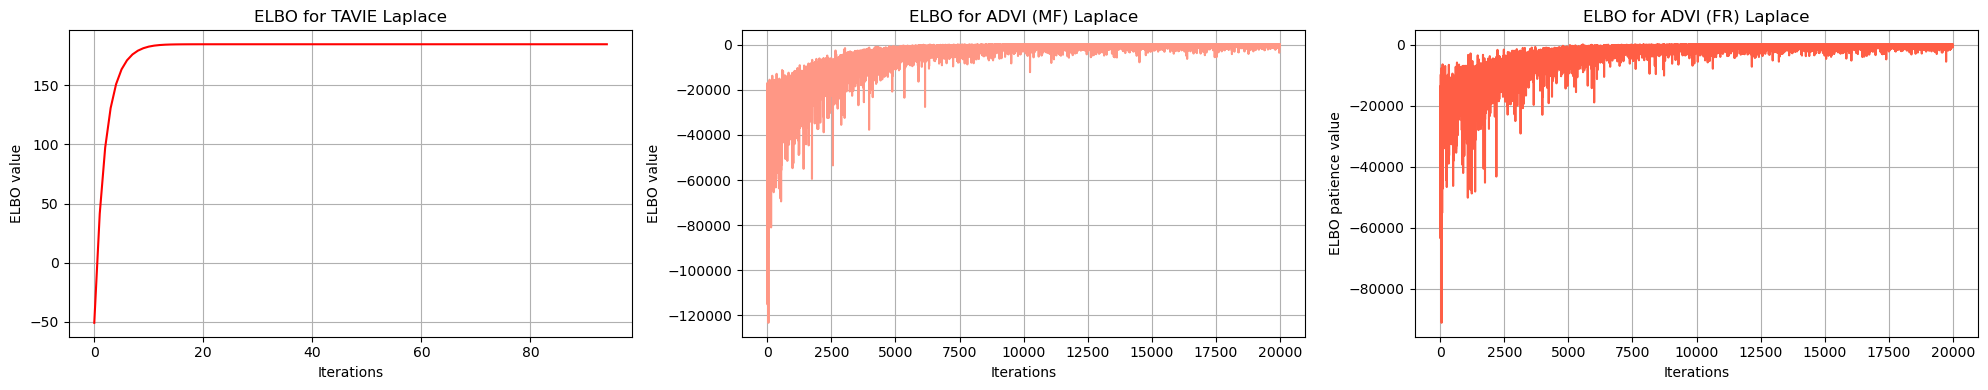

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4), sharex=False, sharey=False)

# TAVIE ELBO
axes[0].plot(ELBO[6:], color='red')
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('ELBO value')
axes[0].set_title("ELBO for TAVIE Laplace")
axes[0].grid(True)

# ADVI (MF) ELBO
axes[1].plot(elbo_advi_mf[6:], color='#FF9785')
axes[1].set_xlabel('Iterations')
axes[1].set_ylabel('ELBO value')
axes[1].set_title("ELBO for ADVI (MF) Laplace")
axes[1].grid(True)

# ADVI (FR) ELBO
axes[2].plot(elbo_advi_fr[6:], color='#FF5E45')
axes[2].set_xlabel('Iterations')
axes[2].set_ylabel('ELBO patience value')
axes[2].set_title("ELBO for ADVI (FR) Laplace")
axes[2].grid(True)

plt.tight_layout()
plt.show()

### Convergence of TAVIE and BBVI for Student's t likelihood (SSG Type I)

For BBVI we use two different BBVI (ADVI) algorithms:
* ADVI with mean-field assumption (ADVI MF), and
* ADVI with full-rank structure (ADVI FR).

In [17]:
# Simulated data
n = 10000
p = 5
tau2 = 8
nu_true = 5

# Design matrix, true regression coefficients and response
X = np.random.normal(size=(n, p))
beta_true = np.random.normal(loc=0.0, scale=1.0, size=p+1)
error =  np.random.standard_t(size = n, df = nu_true) * 1/np.sqrt(tau2)
y = beta_true[0] + X @ beta_true[1:len(beta_true)] + error

# Initialize the TAVIE model for student's-t likelihood
student_model = TAVIE_loc_scale(family="student", fit_intercept=True)
student_model.fit(X, y, nu=nu_true, verbose=False) # fit the TAVIE model
res1 = student_model.get_TAVIE_means(verbose=False) # get the TAVIE estimates
ELBO = student_model.get_elbo() # get the ELBO across iterations
# obtain the variational parameter estimates; use variational_estimates as required
variational_estimates = student_model.get_variational_estimates()
beta_est1, tau2_est1 = res1

# ADVI (MF) and ADVI (FR) estimators
X_bbvi = np.column_stack((np.ones(n), X))
Sigma_prior = np.eye(p+1)
a0 = 0.05
b0 = 0.05
res2 = BBVI_student_patience_best(X_bbvi, y, nu=nu_true, a0=a0, b0=b0, patience=1e4, verbose=False)
res3 = BBVI_student_fullcov_AdamW_best(X_bbvi, y, nu=nu_true, Sigma_prior=Sigma_prior, a0=a0, b0=b0, patience=1e4, verbose=False)
beta_est2 = res2['beta_mean']
tau2_est2 = res2['tau2_mean']
beta_est3 = res3['beta_mean']
tau2_est3 = res3['tau2_mean']
ELBO_advi_mf = res2['elbo_hist']
ELBO_advi_fr = res3['elbo_hist']

# displaying the TAVIE and BBVI estimates
param_names = ["beta0"] + [f"beta{i}" for i in range(1, len(beta_true))] + ["tau2"]

# Stack true and estimated values
true_vals   = np.concatenate([beta_true,  [tau2]])
tavie_vals  = np.concatenate([beta_est1,  [tau2_est1]])
advi_mf_vals   = np.concatenate([beta_est2,  [tau2_est2]])
advi_fr_vals   = np.concatenate([beta_est3,  [tau2_est3]])

# Construct the DataFrame of results
df_estimates = pd.DataFrame(
    {
        "true":  true_vals,
        "TAVIE": tavie_vals,
        "ADVI (MF)":  advi_mf_vals,
        "ADVI (FR)": advi_fr_vals,
    },
    index=param_names
)

df_estimates

,true,TAVIE,ADVI (MF),ADVI (FR)
beta0,-0.705229,-0.703184,-0.706240,-0.704422
beta1,2.164169,2.161676,2.158763,2.160653
beta2,1.435032,1.438340,1.440433,1.441681
beta3,-1.176622,-1.172730,-1.172896,-1.167679
beta4,-0.791805,-0.793181,-0.790880,-0.797665
beta5,-1.093254,-1.090334,-1.096779,-1.088593
tau2,8.000000,8.030251,8.723781,8.887009


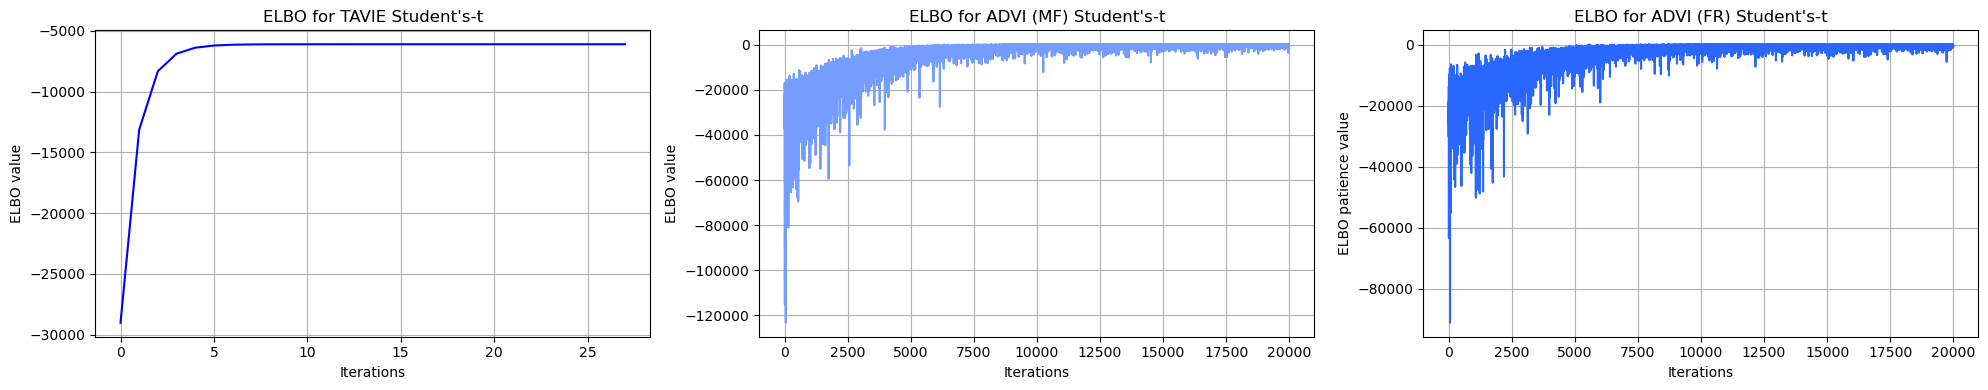

In [19]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4), sharex=False, sharey=False)

# TAVIE ELBO
axes[0].plot(ELBO[6:], color='blue')
axes[0].set_xlabel('Iterations')
axes[0].set_ylabel('ELBO value')
axes[0].set_title("ELBO for TAVIE Student's-t")
axes[0].grid(True)

# ADVI (MF) ELBO
axes[1].plot(elbo_advi_mf[6:], color='#759DFF')
axes[1].set_xlabel('Iterations')
axes[1].set_ylabel('ELBO value')
axes[1].set_title("ELBO for ADVI (MF) Student's-t")
axes[1].grid(True)

# ADVI (FR) ELBO
axes[2].plot(elbo_advi_fr[6:], color='#2967FF')
axes[2].set_xlabel('Iterations')
axes[2].set_ylabel('ELBO patience value')
axes[2].set_title("ELBO for ADVI (FR) Student's-t")
axes[2].grid(True)

plt.tight_layout()
plt.show()